# Graph
[Draw] graphs using the [ForceAtlas2] energy model. Graphs can be [directed] and/or [weighted].

For a larger example, see the [7 Degrees of Martin Brundle].


[Draw]: https://en.wikipedia.org/wiki/Graph_drawing
[ForceAtlas2]: https://doi.org/10.1371/journal.pone.0098679
[directed]: https://en.wikipedia.org/wiki/Directed_graph
[weighted]: https://en.wikipedia.org/wiki/Glossary_of_graph_theory#weighted_graph
[7 Degrees of Martin Brundle]: https://brundling.neocities.org/

In [1]:
from graph import GraphFrame

In [2]:
%load_ext autoreload
%autoreload all

from graph import *

<Axes: xlabel='x', ylabel='y'>

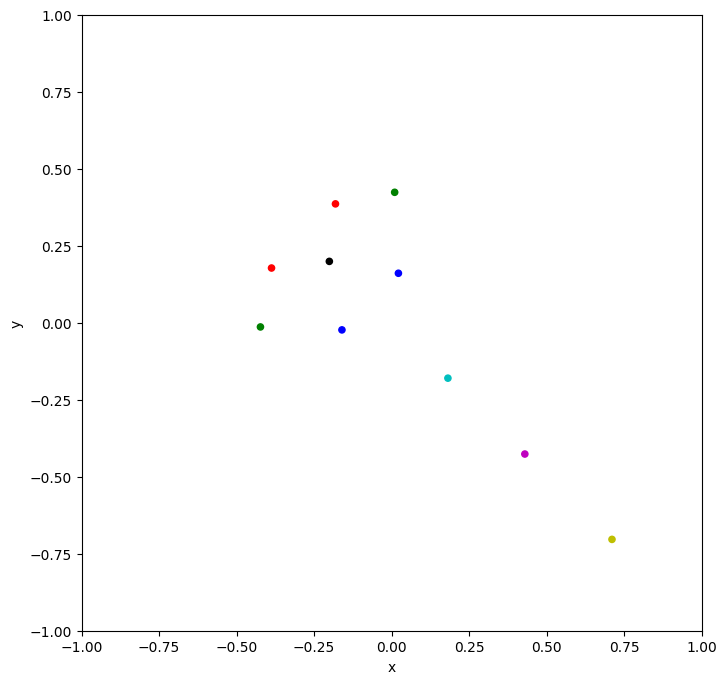

In [8]:
kite = GraphFrame.example()
kite.plot(color=list('rrgkgbbcmy'))

## build a GraphFrame
GraphFrame can import and export several different graph data structures.

Internally, each graph is stored as a DataFrame with 3 columns: `source`, `target`, `weight`.

For example, if the node named `a` points to the node named `b` with weight 0.1, that information is stored as the row `('a', 'b', 0.1)`.

[directed graph]: https://en.wikipedia.org/wiki/Directed_graph

**from triples:** Each link is a (source, target, weight) tuple.

In [ ]:
triples = (
    ('alice', 'bob', 2),
    ('alice', 'carol', 1),
    ('bob', 'alice', 1),
    ('bob', 'carol', 1),
    ('carol', 'alice', 1),
)
graph = GraphFrame(triples)
graph

**from pairs:** Each link is a (source, target) tuple.

Links are weighted by how often they appear.

In [ ]:
pairs = (
    ('alice', 'bob'),
    ('alice', 'bob'),
    ('alice', 'carol'),
    ('bob', 'alice'),
    ('bob', 'carol'),
    ('carol', 'alice'),
)
GraphFrame(pairs)

**from sources:** Each node is a key. Each value is the list of nodes which point to that key.

In [ ]:
sources = dict()
sources['alice'] = ['bob', 'carol']
sources['bob'] = ['alice', 'alice']
sources['carol'] = ['alice','bob']
GraphFrame.from_sources(sources)

**from targets:** Each node is a key. Each value is a list of nodes to which that key points.

In [ ]:
targets = dict()
targets['alice'] = ['bob', 'bob', 'carol']
targets['bob'] = ['alice', 'carol']
targets['carol'] = ['alice']
GraphFrame.from_targets(targets)

**by [transposing] a GraphFrame**

[transposing]: https://en.wikipedia.org/wiki/Transpose_graph

In [ ]:
graph.flipped()

## export graph attributes

In [ ]:
# Access the internal DataFrame directly
graph.links

In [ ]:
# links as a SciPy sparse adjacency matrix
graph.matrix

In [ ]:
# links as a NumPy adjacency matrix
graph.matrix.toarray()

In [ ]:
# list of all distinct nodes
graph.nodes

In [ ]:
# Series of weights for each distinct (source, target)
graph.weights

## iterate over a graph

In [ ]:
# iterate over links (as namedtuples)
for link in graph:
    print(link)

In [ ]:
# iterate over links (as components)
for s,t,w in graph:
    print(f"{s} -> {t} : {w}")

In [ ]:
# iterate over links without weights
for s,t in graph.pairs():
    print(f"{s} -> {t}")

In [ ]:
# map each source to a list of its targets
{x:y for x,y in graph.targets()}

In [ ]:
# map each target to a list of its sources
{x:y for x,y in graph.sources()}

## calculate coordinates

In [ ]:
graph.coords()

## plot coordinates

In [ ]:
graph.plot(color=list('rgb'))

## show timesteps

In [ ]:
plotkw = {
    'color': list('rgb'),
    'figsize': (4,4),
    'x': 'x',
    'xlim': (-1,1),
    'y': 'y',
    'ylim': (-1,1)
}

for t, frame in enumerate(graph(128)):
    if not (t % 16):
        frame.plot.scatter(**plotkw)

## help

In [ ]:
help(GraphFrame)